# This notebook is to train a cat vs. dog identifier
- Use InceptionV3 as a starting point
- Train a transfer learning model via cats vs. dogs image examples 
- Use my cats, Mia and Kiki, to test the models
- In the future, I will implement a cats vs. non-cats model to truly make it a cat identifier

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# take inception V3 as a pre-trained model
pre_trained_model = InceptionV3(
    input_shape = (150, 150, 3), 
    include_top = False, 
    weights = None
)

pre_trained_model.load_weights(local_weights_file)

# freeze all the weights in this inception V3 network
for layer in pre_trained_model.layers:
  layer.trainable = False

# feel free to print out the summary to get an idea of the network structure  
# pre_trained_model.summary()

# get the last layer
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-05-23 21:14:55--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c13::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   139MB/s    in 0.6s    

2020-05-23 21:14:55 (139 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


In [0]:
from tensorflow.keras.optimizers import RMSprop

# set up our neural network structure for the last few layers

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                 
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

# train the model using RMSprop
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [3]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2020-05-23 21:15:35--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c15::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   160MB/s    in 0.4s    

2020-05-23 21:15:36 (160 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 18s - loss: 0.3353 - accuracy: 0.8680 - val_loss: 0.1189 - val_accuracy: 0.9510
Epoch 2/20
100/100 - 17s - loss: 0.2274 - accuracy: 0.9145 - val_loss: 0.0925 - val_accuracy: 0.9650
Epoch 3/20
100/100 - 17s - loss: 0.2046 - accuracy: 0.9225 - val_loss: 0.1537 - val_accuracy: 0.9520
Epoch 4/20
100/100 - 17s - loss: 0.1941 - accuracy: 0.9265 - val_loss: 0.0779 - val_accuracy: 0.9710
Epoch 5/20
100/100 - 17s - loss: 0.1772 - accuracy: 0.9350 - val_loss: 0.1100 - val_accuracy: 0.9590
Epoch 6/20
100/100 - 17s - loss: 0.1757 - accuracy: 0.9405 - val_loss: 0.1107 - val_accuracy: 0.9670
Epoch 7/20
100/100 - 17s - loss: 0.1737 - accuracy: 0.9430 - val_loss: 0.1190 - val_accuracy: 0.9560
Epoch 8/20
100/100 - 17s - loss: 0.1794 - accuracy: 0.9425 - val_loss: 0.1078 - val_accuracy: 0.9690
Epoch 9/20
100/100 - 17s - loss: 0.2006 - accuracy: 0.9390 - val_loss: 0.1081 - val_accuracy: 0.9680
Epoch 10/20
100/100 - 17s - loss: 0.1620 - accuracy: 0.9490 - val_loss: 0.1031 - val_accura

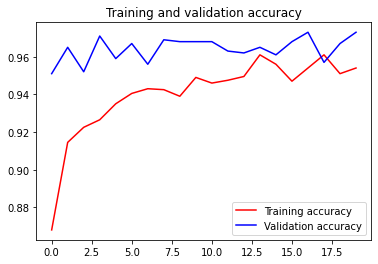

<Figure size 432x288 with 0 Axes>

In [5]:
# check the training/validation results

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# The fun part: Using my cats as examples!
- Just Mia
- Just Kiki
- Mia + Kiki
- Kiki + my fiancee
- Mia upside-down
- some other variations

Saving IMG_3249.jpg to IMG_3249.jpg


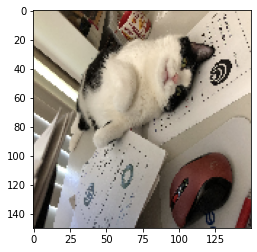

[0.]
IMG_3249.jpg is a cat


Saving IMG_2940.JPG to IMG_2940 (2).JPG


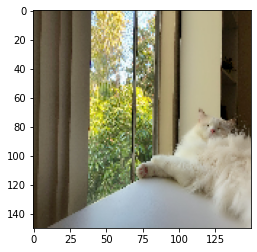

[0.]
IMG_2940.JPG is a cat


Saving IMG_6626.jpg to IMG_6626.jpg


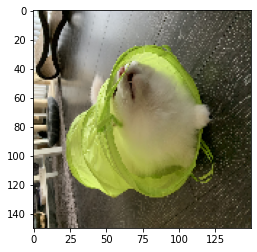

[0.]
IMG_6626.jpg is a cat


Saving IMG_6625.jpg to IMG_6625.jpg


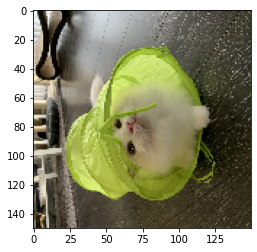

[0.]
IMG_6625.jpg is a cat


Saving IMG_3356.jpg to IMG_3356.jpg


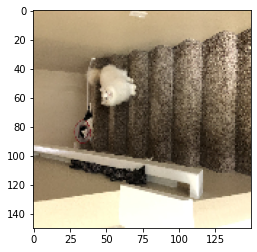

[0.]
IMG_3356.jpg is a cat


Saving IMG_6645.jpg to IMG_6645.jpg


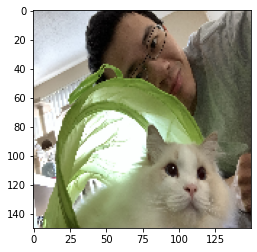

[0.]
IMG_6645.jpg is a cat


Saving IMG_6640.JPG to IMG_6640.JPG


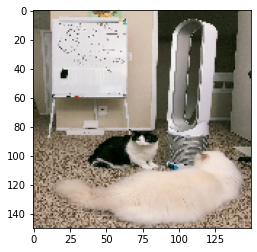

[0.]
IMG_6640.JPG is a cat


In [0]:


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import files
from keras.preprocessing import image

while True:
  uploaded=files.upload()

  for fn in uploaded.keys():
 
    # predicting images
    path='/content/' + fn
    img=image.load_img(path, target_size=(150, 150))
    plt.imshow(img)
    plt.show()
  
    x=image.img_to_array(img)
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])
  
    classes = model.predict(images, batch_size=10)
  
    print(classes[0])
  
    if classes[0]>0:
      print(fn + " is a dog")
    
    else:
      print(fn + " is a cat")